# Read the refer path information by CNN

At the beginning, I have a mp4 file which record my game and a csv file which show the distance between the car and the refer path.
I run the command below in Linux:


A Sequence of pictures from the mp4 file were made and saved in pic2/. The name of the pictures are 1.jpeg,2.jpeg,...
Every picture is related to a line in the csv file, that is, the distance in the picture is the float in the csv file.
What I want to do is to learn the distance through CNN.

In [2]:

from __future__ import print_function, division
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms,utils
import matplotlib.pyplot as plt
import time
import copy
import os

plt.ion()

In [3]:
import pandas as pd
from skimage import io, transform
import numpy as np
from torch.utils.data import Dataset, DataLoader
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")



Here I buid my own dataset class for future use:

In [7]:
class VideoLandmarksDataset(Dataset):
    """video Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        #img_name = os.path.join(self.root_dir, self.landmarks_frame.ix[idx],'.jpg')
        img_name = self.root_dir+'/'+str(idx+120)+'.jpeg'
        image = io.imread(img_name)
        #landmarks = self.landmarks_frame.ix[idx].astype('float')
        tmp= self.landmarks_frame.ix[idx,0]
        landmarks=torch.DoubleTensor(1,1)
        landmarks[0]= tmp
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [9]:
def show_im(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)

In [5]:
video_dataset = VideoLandmarksDataset(csv_file='datas/data0912/labelfinal.csv',
                                    root_dir='datas/data0912/pic2')

148.0
0 (568, 1208, 3) torch.Size([1, 1])
1 (568, 1208, 3) torch.Size([1, 1])
2 (568, 1208, 3) torch.Size([1, 1])
3 (568, 1208, 3) torch.Size([1, 1])


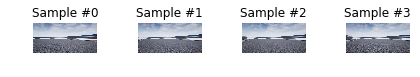

In [11]:

fig = plt.figure()
print (len(video_dataset)/4)
for i in range(len(video_dataset)):
    sample = video_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_im(**sample)

    if i == 3:
        plt.show()
        break

The transform class is the similiar with Scale,Totensor,Normaliaze module in torchvision.transforms.

In [12]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        

        return {'image': img, 'landmarks': landmarks}


In [13]:

class ToTensors(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float(),
                'landmarks': landmarks}

In [14]:
class Normalize2(object):
    """Normalize an tensor image with mean and standard deviation.
    Given mean: (R, G, B) and std: (R, G, B),
    will normalize each channel of the torch.*Tensor, i.e.
    channel = (channel - mean) / std
    Args:
        mean (sequence): Sequence of means for R, G, B channels respecitvely.
        std (sequence): Sequence of standard deviations for R, G, B channels
            respecitvely.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        # TODO: make efficient
        tensor,landmarks = sample['image'],sample['landmarks']
        #tensor = torch.from_numpy(tensor)
        for t, m, s in zip(tensor, self.mean, self.std):
            t.sub_(m).div_(s)
        return {'image':tensor,'landmarks':landmarks}

In [15]:


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        #landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

In [16]:
transformed_dataset = VideoLandmarksDataset(csv_file='datas/data0912/labelfinal.csv',
                                           root_dir='datas/data0912/pic2',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               ToTensors()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    sample2=sample['image']

    print(i, sample['image'].size(),sample['landmarks'])

    if i == 3:
        break

0 torch.Size([3, 256, 544]) 
-87.6977
[torch.DoubleTensor of size 1x1]

1 torch.Size([3, 256, 544]) 
-86.0649
[torch.DoubleTensor of size 1x1]

2 torch.Size([3, 256, 544]) 
-86.1962
[torch.DoubleTensor of size 1x1]

3 torch.Size([3, 256, 544]) 
-88.3286
[torch.DoubleTensor of size 1x1]



In [17]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)
ylabels = pd.read_csv('datas/data0912/labelfinal.csv')
print(ylabels.ix[0,0])
n= int(len(ylabels)/4)
print(n)
l=[]
labels=[[0]*4 for __ in range(n)]
for i in range(n):
    for j in range(4):
        labels[i][j] = ylabels.ix[i*4+j,0]

#print(labels)


-87.697685
148


0 torch.Size([4, 3, 256, 544])
1 torch.Size([4, 3, 256, 544])
2 torch.Size([4, 3, 256, 544])
3 torch.Size([4, 3, 256, 544])
4 torch.Size([4, 3, 256, 544])
5 torch.Size([4, 3, 256, 544])
6 torch.Size([4, 3, 256, 544])
7 torch.Size([4, 3, 256, 544])


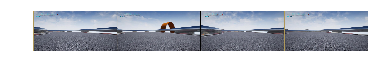

148


In [18]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    #for i in range(batch_size):
        ###s=10, marker='.', c='r')
        

        #plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 7:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        print(len(dataloader))
        break


In [23]:
class CNN(nn.Module):
    def __init__(self):
        #cnn
        super(CNN, self).__init__()
        #256
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1)
        self.relu1 = nn.ReLU(True)
        #128
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1) 
        self.relu2 = nn.ReLU(True)
        #64
        self.conv3 = nn.Conv2d(64, 32, 4, 2, 1)
        self.relu3 = nn.ReLU(True)
        #32
        self.conv4 = nn.Conv2d(32, 8, 4, 2, 1)
        self.relu4 = nn.ReLU(True)
        #16
        self.conv5 = nn.Conv2d(8, 4, 4, 2, 1)
        self.relu5 = nn.ReLU(True)
        #8
        
        self.fc1 = nn.Linear(544, 64)
        self.fc2 = nn.Linear(64, 8)
        self.fc3 = nn.Linear( 8, 1)
        #add linear
        

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.relu5(self.conv5(x))
        x = x.view(4, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = CNN()
print(net)

CNN (
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU (inplace)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU (inplace)
  (conv3): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU (inplace)
  (conv4): Conv2d(32, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu4): ReLU (inplace)
  (conv5): Conv2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu5): ReLU (inplace)
  (fc1): Linear (544 -> 64)
  (fc2): Linear (64 -> 8)
  (fc3): Linear (8 -> 1)
)


In [24]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=1.0)

In [26]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        # get the inputs
        #print (i)
        inputs= data['image']
        a=[0]*4
        for j in range(4):
            a[j]=ylabels.ix[i*4+j,0]
        labels2=np.array([a[0],a[1],a[2],a[3]],dtype=np.float32)
        labels2= torch.from_numpy(labels2)


        # wrap them in Variable
        inputs,targets = Variable(inputs), Variable(labels2/100)
# zero the parameter gradients
        optimizer.zero_grad()
        

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

Process Process-14:
Process Process-16:
Process Process-13:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/yicong/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/yicong/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/yicong/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/yicong/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yicong/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yicong/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yicong/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.p

KeyboardInterrupt: 

In [27]:
for i ,data in enumerate(dataloader):
    inputs=Variable(data['image']) 
    out = net(inputs)
    #labels2=np.array([[float(ylabels.ix[i*4,0])],[ylabels.ix[i*4+1,0]],[ylabels.ix[i*4+2,0]],[ylabels.ix[i*4+3,0]]],dtype=np.float32)
    #labels2= torch.from_numpy(labels2/100)
    print(out)
    #if i==15:
        #break

Process Process-17:
Process Process-18:
Process Process-20:
Traceback (most recent call last):


Variable containing:
 1.5766e+08
 1.5766e+08
 1.5766e+08
 1.5766e+08
[torch.FloatTensor of size 4x1]



  File "/home/yicong/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-19:
  File "/home/yicong/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yicong/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
Traceback (most recent call last):
  File "/home/yicong/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/yicong/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 40, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/yicong/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/yicong/anaconda3/lib/python3.6/multiprocessing/process.py", line 

KeyboardInterrupt: 